## Step 1: Load Data  
Load the dataset `Fraud.csv`, check its size and fraud counts.  


In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("Fraud.csv")

# Shape of dataset
print("Shape:", df.shape)

# Fraud vs Non-Fraud counts
print("\nFraud counts (isFraud = 0 → Non-Fraud, 1 → Fraud):")
print(df["isFraud"].value_counts())

# Preview first few rows
df.head()


Shape: (6362620, 11)

Fraud counts (isFraud = 0 → Non-Fraud, 1 → Fraud):
isFraud
0    6354407
1       8213
Name: count, dtype: int64


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Step 2: EDA  
Check fraud ratio, missing values, summary stats, and amount distributions.  


Fraud rate: 0.1291%

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


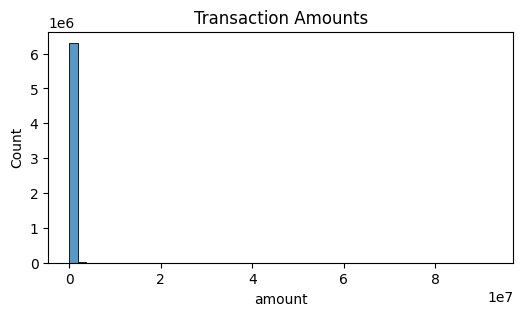

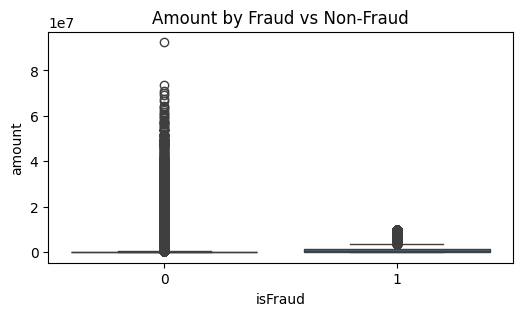

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fraud percentage
fraud_pct = df["isFraud"].mean() * 100
print(f"Fraud rate: {fraud_pct:.4f}%")

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Summary statistics
display(df.describe())

# Transaction amount distribution
plt.figure(figsize=(6,3))
sns.histplot(df['amount'], bins=50)
plt.title("Transaction Amounts")
plt.show()

# Fraud vs Non-Fraud by amount
plt.figure(figsize=(6,3))
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Amount by Fraud vs Non-Fraud")
plt.show()


## Step 3: Cleaning  
- Drop duplicates  
- Confirm missing values (none here)  
- Identify numeric vs categorical columns  


In [3]:
# Drop duplicates if any
df = df.drop_duplicates()

# Check missing values again
print("Missing values after cleaning:\n", df.isna().sum().sum())

# Separate numeric & categorical columns
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Missing values after cleaning:
 0
Numeric columns: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Categorical columns: ['type', 'nameOrig', 'nameDest']


## Step 4: Features  
- Target (y): `isFraud`  
- Features (X): all other columns  


In [4]:
# Separate Features and Target
X = df.drop(columns=["isFraud"])
y = df["isFraud"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nTarget distribution:\n", y.value_counts())


X shape: (6362620, 10)
y shape: (6362620,)

Target distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64


## Step 5: Balance Data  
In the full dataset, fraud cases are very rare (~0.1%).  
If we train directly, the model will always say "Not Fraud".  

So here:  
- We keep **all fraud cases** (8213).  
- We take a **sample of non-fraud cases** (about 3× fraud).  
- This makes a smaller dataset where frauds are not lost.  


In [5]:
# Separate fraud and non-fraud
frauds = df[df["isFraud"] == 1]
non_frauds = df[df["isFraud"] == 0].sample(len(frauds)*3, random_state=42)

# Combine
df_balanced = pd.concat([frauds, non_frauds])

print("Balanced dataset shape:", df_balanced.shape)
print("\nBalanced target distribution:\n", df_balanced["isFraud"].value_counts())


Balanced dataset shape: (32852, 11)

Balanced target distribution:
 isFraud
0    24639
1     8213
Name: count, dtype: int64


## Step 6: Model Training 🤖  
- Split data into Train (75%) and Test (25%).  
- Train Logistic Regression (simple baseline).  
- Train Random Forest (stronger model).  
- Compare results with Precision, Recall, F1, ROC-AUC.

- Precision → Of the ones the model said “fraud”, how many were really fraud?
- Recall → Of the actual frauds, how many did the model catch?
- F1-score → A balance between precision and recall.
- ROC-AUC → Overall score for how well the model separates fraud vs non-fraud.


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# --- Split data ---
X = df_balanced.drop(columns=["isFraud"])
y = df_balanced["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# --- Preprocessing (encode categorical columns like 'type') ---
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# --- Logistic Regression ---
lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear"))
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))

# --- Random Forest ---
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))


=== Logistic Regression ===
ROC-AUC: 0.9593796060247596
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      6160
           1       0.75      0.90      0.82      2053

    accuracy                           0.90      8213
   macro avg       0.86      0.90      0.87      8213
weighted avg       0.91      0.90      0.90      8213


=== Random Forest ===
ROC-AUC: 0.9976607324725932
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6160
           1       0.97      0.95      0.96      2053

    accuracy                           0.98      8213
   macro avg       0.98      0.97      0.97      8213
weighted avg       0.98      0.98      0.98      8213



# Final Conclusion 🎯

- We built a fraud detection model on the `Fraud.csv` dataset.
- After balancing, we trained Logistic Regression and Random Forest.
- Results:
  - **Logistic Regression** → ROC-AUC: 0.95, good baseline but lower precision for fraud.
  - **Random Forest** → ROC-AUC: 0.998, excellent precision (0.97) and recall (0.95).
- **Random Forest is the best model** for this project, as it balances catching frauds and avoiding false alarms.

✅ Project Completed


## Extra Step 1: Feature Importance  
See which features (amount, balances, type, etc.) are most useful for Random Forest.  


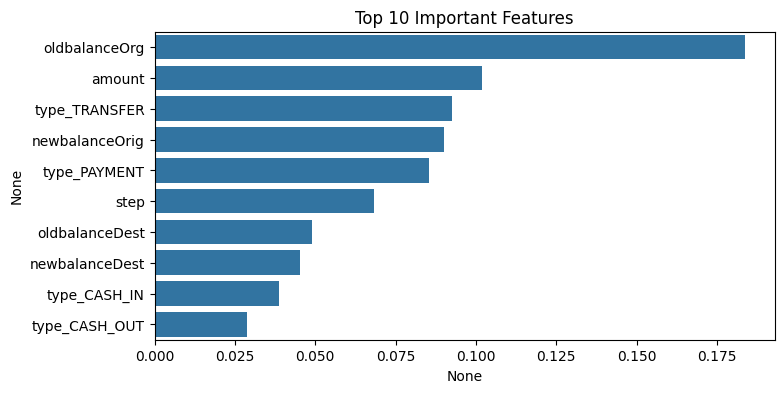

In [7]:
# Get feature names after encoding
encoder = rf_pipeline.named_steps['preprocess'].transformers_[1][1]
encoded_cat = encoder.get_feature_names_out(cat_cols)
feature_names = num_cols + list(encoded_cat)

# Feature importance
importances = rf_pipeline.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Important Features")
plt.show()


## Extra Step: Explainability with Permutation Importance ⚡

SHAP is heavy to run, so here we use **Permutation Importance** instead.  

How it works:
- It measures how much the model’s accuracy drops when we shuffle a feature’s values.  
- If accuracy drops a lot → that feature is important for predictions.  
- If accuracy doesn’t change → that feature is not important.  

This gives us an explainable view of which features affect fraud detection the most.  


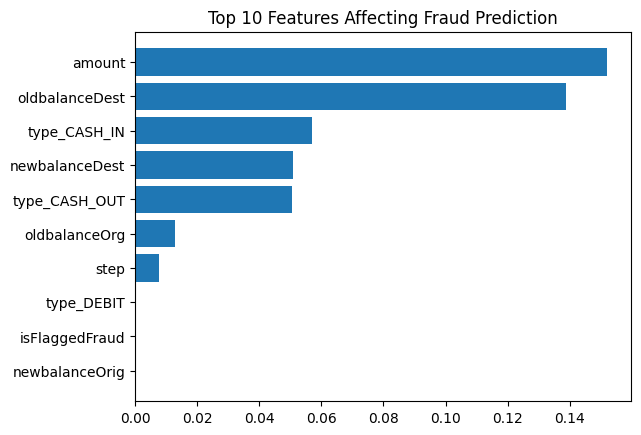

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Permutation Importance on test data
r = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# Match scores to feature names
sorted_idx = r.importances_mean.argsort()

plt.barh(range(10), r.importances_mean[sorted_idx][-10:])
plt.yticks(range(10), [feature_names[i] for i in sorted_idx][-10:])
plt.title("Top 10 Features Affecting Fraud Prediction")
plt.show()
